In [1]:
import pandas as pd
import numpy as np
import torch
import ast
from sentence_transformers import SentenceTransformer, util
from lex_index import LexIndex, Chunk

In [2]:
def cosine_to_unit(scores: torch.Tensor) -> torch.Tensor:
    return (scores + 1.0) / 2.0


def load_faq_data(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df["embedding"] = df["embedding"].apply(lambda x: np.array(ast.literal_eval(x), dtype=np.float32))
    return df


def build_lex_index(df: pd.DataFrame) -> LexIndex:
    chunks = [
        Chunk(id=i, text=df.iloc[i]["question"], meta={"answer": df.iloc[i]["answer"]})
        for i in range(len(df))
    ]
    return LexIndex(chunks)

In [3]:
class HybridFAQ:
    def __init__(self, faq_csv: str, w_embed: float = 0.5, w_lex: float = 0.5, threshold: float = 0.5):
        self.w_embed = w_embed
        self.w_lex = w_lex
        self.threshold = threshold

        self.df = load_faq_data(faq_csv)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
        self.model.to(self.device)

        self.embeddings = torch.tensor(
            np.stack(self.df["embedding"].values),
            device=self.device
        )

        self.lex_index = build_lex_index(self.df)


    def search(self, query: str, top_k: int = 5):
        query_emb = self.model.encode([query], convert_to_tensor=True).to(self.device)

        cos_scores = util.cos_sim(query_emb, self.embeddings)[0]
        embed_scores = cosine_to_unit(cos_scores)

        lex_scores = torch.tensor(
            self.lex_index.score_all(query),
            dtype=torch.float32,
            device=self.device
        )

        hybrid = self.w_embed * embed_scores + self.w_lex * lex_scores

        top_idx = torch.argsort(hybrid, descending=True)[:top_k]

        results = []
        for idx in top_idx:
            idx = int(idx)

            results.append({
                "query": query,
                "question": self.df.iloc[idx]["question"],
                "answer": self.df.iloc[idx]["answer"],
                "lex_score": float(lex_scores[idx]),
                "embed_score": float(embed_scores[idx]),
                "hybrid_score": float(hybrid[idx])
            })

        if len(results) == 0 or results[0]["hybrid_score"] < self.threshold:
            return {
                "query": query,
                "has_answer": False,
                "top_hits": results
            }

        return {
            "query": query,
            "has_answer": True,
            "top_hits": results
        }

In [4]:
def test_queries(queries_file: str, faq_csv: str, output_csv: str):
    hybrid = HybridFAQ(faq_csv, w_embed=0.5, w_lex=0.5, threshold=0.5)

    with open(queries_file, "r", encoding="utf-8") as f:
        queries = [q.strip() for q in f.readlines() if q.strip()]

    all_rows = []

    for query in queries:
        print("Processing:", query)
        res = hybrid.search(query, top_k=5)

        if not res["has_answer"]:
            all_rows.append({
                "query": query,
                "question": None,
                "answer": "NO_ANSWER",
                "lex_score": None,
                "embed_score": None,
                "hybrid_score": None
            })
            continue

        for hit in res["top_hits"]:
            all_rows.append(hit)

    df_out = pd.DataFrame(all_rows)
    df_out.to_csv(output_csv, index=False)
    print("Saved:", output_csv)

In [5]:
test_queries("queries.txt", "faq_data.csv", "results.csv")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing: У нас в подъезде перегорела лампочка, кто её меняет?
Processing: Как подать заявку на ремонт в квартире от управляющей компании?
Processing: Когда придёт электрик проверить проводку?
Processing: Почему у нас в подъезде холодно, работает ли отопление?
Processing: Как оставить обращение в аварийную службу?
Processing: Не работает лифт, когда его починят?
Processing: Куда сообщить о шумных соседях поздно вечером?
Processing: Как передать показания по воде, если не работает личный кабинет?
Processing: Кто отвечает за уборку снега во дворе?
Processing: Как поменять магнитный ключ от входной двери?
Processing: Почему у нас отключили свет без предупреждения?
Processing: Как получить справку о проживании?
Processing: В квартире запах газа, куда звонить?
Processing: Когда будет дезинсекция от тараканов?
Processing: Можно ли заказать вывоз крупного мусора?
Processing: Как узнать, почему по квитанции начислено больше обычного?
Processing: Как вызвать специалиста для проверки батарей?


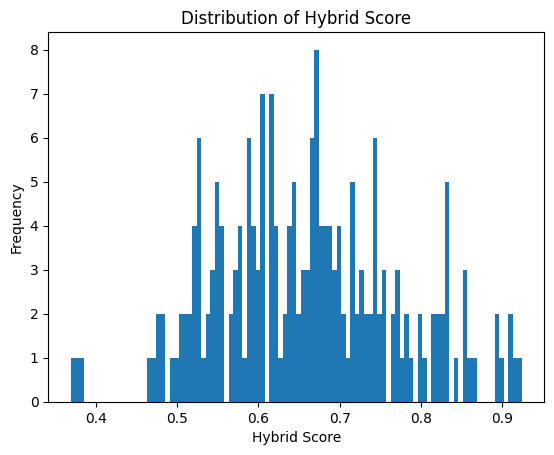

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results.csv")

plt.hist(df["hybrid_score"], bins=100)
plt.xlabel("Hybrid Score")
plt.ylabel("Frequency")
plt.title("Distribution of Hybrid Score")
plt.show()
